# 필요한 라이브러리 불러오기

In [26]:
import pandas as pd
import numpy as np
import datetime as dt

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

%matplotlib inline

# matplotlib 한글 깨짐 해결
plt.rcParams['font.family'] = 'AppleGothic' # For MacOS
plt.rcParams['axes.unicode_minus'] =False

# Seaborn 폰트 설정
sns.set(font='AppleGothic') # 사용하고 있는 한글 폰트로 변경

print(plt.rcParams['font.family'])

['AppleGothic']


In [27]:
users_df = pd.read_csv('train_users_2.csv')
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [28]:
sessions_df = pd.read_csv('sessions.csv')
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [29]:
sessions_df.count()

user_id          10533241
action           10488111
action_type       9441533
action_detail     9441533
device_type      10567737
secs_elapsed     10431706
dtype: int64

In [30]:
sessions_df.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

# users_df 전처리

In [31]:
# age 컬럼에서 18세 이상 122세 이하의 값을 제외한 나머지 값을 null로 처리
users_df.loc[(users_df['age'] < 18) | (users_df['age'] > 122), 'age'] = np.nan

users_df.age.isnull().sum()

88929

In [32]:
# 변환할 컬럼 지정
columns_to_convert = [
    'gender', 'signup_method', 'language', 'affiliate_channel', 
    'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 
    'first_device_type', 'first_browser', 'country_destination'
]

for column in columns_to_convert:
    users_df[column] = users_df[column].astype('category')

print(users_df.dtypes)

id                           object
date_account_created         object
timestamp_first_active        int64
date_first_booking           object
gender                     category
age                         float64
signup_method              category
signup_flow                   int64
language                   category
affiliate_channel          category
affiliate_provider         category
first_affiliate_tracked    category
signup_app                 category
first_device_type          category
first_browser              category
country_destination        category
dtype: object


In [33]:
# date_account_created 및 date_first_booking 컬럼을 datetime 타입으로 변환
users_df['date_account_created'] = pd.to_datetime(users_df['date_account_created'])
users_df['date_first_booking'] = pd.to_datetime(users_df['date_first_booking'])

# timestamp_first_active는 타임스탬프 형식으로 되어있으므로 변환
users_df['timestamp_first_active'] = pd.to_datetime(users_df['timestamp_first_active'], format='%Y%m%d%H%M%S')

In [34]:
# 확인
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       213451 non-null  object        
 1   date_account_created     213451 non-null  datetime64[ns]
 2   timestamp_first_active   213451 non-null  datetime64[ns]
 3   date_first_booking       88908 non-null   datetime64[ns]
 4   gender                   213451 non-null  category      
 5   age                      124522 non-null  float64       
 6   signup_method            213451 non-null  category      
 7   signup_flow              213451 non-null  int64         
 8   language                 213451 non-null  category      
 9   affiliate_channel        213451 non-null  category      
 10  affiliate_provider       213451 non-null  category      
 11  first_affiliate_tracked  207386 non-null  category      
 12  signup_app      

# 세션 타임스탬프 만들기

## (1) secs_elapsed 이상치, NaN값 처리
- action 별 이상치 : 해당하는 행 제거 
- NaN값 : action 별 평균값으로 대체

※ 이상치는 boxplot 기준으로 (Q1 – 1.5 * IQR) 보다 작거나 (Q3 + 1.5 * IQR) 보다 큰 데이터를 이상치로 판단했다.

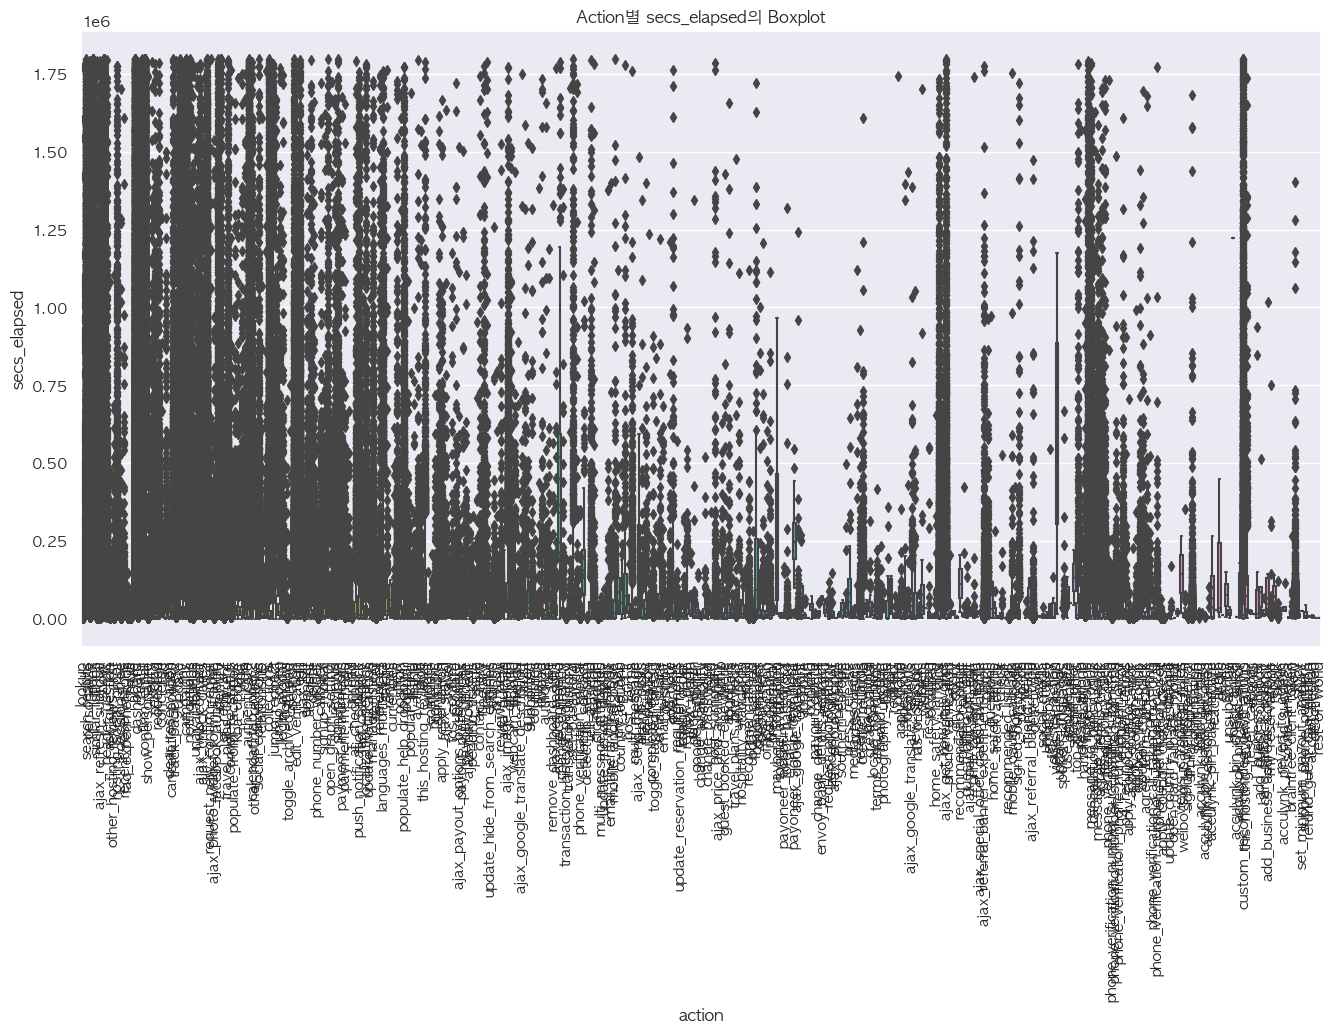

In [35]:
# 박스 플롯으로 데이터 파악
plt.figure(figsize=(16, 8))
sns.boxplot(x='action', y='secs_elapsed', data=sessions_df)
plt.xticks(rotation=90)
plt.title('Action별 secs_elapsed의 Boxplot')
plt.show()

In [36]:
# IQR을 이용한 이상치 제거
Q1 = sessions_df.groupby('action')['secs_elapsed'].transform(lambda x: x.quantile(0.25))
Q3 = sessions_df.groupby('action')['secs_elapsed'].transform(lambda x: x.quantile(0.75))
IQR = Q3 - Q1
outlier_condition = ~(
    (sessions_df['secs_elapsed'] < (Q1 - 1.5 * IQR)) | 
    (sessions_df['secs_elapsed'] > (Q3 + 1.5 * IQR))
)
sessions_df = sessions_df[outlier_condition]

# 개수 확인
sessions_df.count()

user_id          9141598
action           9092126
action_type      8140368
action_detail    8140368
device_type      9171752
secs_elapsed     9035721
dtype: int64

In [37]:
# NaN 값 처리
def fillna_with_mean(group):
    mean_value = group['secs_elapsed'].mean()
    group['secs_elapsed'].fillna(mean_value, inplace=True)
    return group

# DataFrame에 함수 적용
sessions_df = sessions_df.groupby('action').apply(fillna_with_mean)

# 확인
sessions_df.isnull().sum()

user_id            30008
action                 0
action_type      1031384
action_detail    1031384
device_type            0
secs_elapsed           0
dtype: int64

In [38]:
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9092126 entries, ('10', 3356) to ('zendesk_login_jwt', 10164013)
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 795.6+ MB


## (1) 데이터 병합
- users_df의 id 컬럼명을 user_id로 변경한다.
- sessions_df에 users_df의 date_accout_created, date_first_booking, timestamp_fist_active, affiliate_channel (필요하다고 생각한 컬럼만 일단 추출했습니다.)컬럼을 추출하여 user_id 기준으로 LEFT JOIN 했다.

In [41]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   user_id                  213451 non-null  object        
 1   date_account_created     213451 non-null  datetime64[ns]
 2   timestamp_first_active   213451 non-null  datetime64[ns]
 3   date_first_booking       88908 non-null   datetime64[ns]
 4   gender                   213451 non-null  category      
 5   age                      124522 non-null  float64       
 6   signup_method            213451 non-null  category      
 7   signup_flow              213451 non-null  int64         
 8   language                 213451 non-null  category      
 9   affiliate_channel        213451 non-null  category      
 10  affiliate_provider       213451 non-null  category      
 11  first_affiliate_tracked  207386 non-null  category      
 12  signup_app      

In [39]:
# 데이터 병합
users_df.rename(columns={'id': 'user_id'}, inplace=True) # 컬럼 이름 변경
merged_df = sessions_df.merge(users_df[['user_id', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 'affiliate_channel']], on='user_id', how='left')

## (3) 세션 타임스탬프 계산
각 유저id별로 timestamp_first_active(첫 번째 활동의 타임스탬프)에 secs_elapsed(해당 이벤트부터 다음 이벤트까지 세션 경과시간)을 더해서 session_timestamp 컬럼을 새롭게 생성해 그곳에 정보를 담는다.

In [40]:
# 세션 타임스탬프 계산
merged_df['session_timestamp'] = merged_df['timestamp_first_active'] + pd.to_timedelta(merged_df['secs_elapsed'], unit='s')
merged_df

,user_id,action,action_type,action_detail,device_type,secs_elapsed,date_account_created,date_first_booking,timestamp_first_active,affiliate_channel,session_timestamp
0,toga865pvz,10,message_post,message_post,iPhone,38113.0,2014-01-01,NaT,2014-01-01 02:32:47,api,2014-01-01 13:08:00
1,uyb283j6j0,10,message_post,message_post,iPhone,42635.0,2014-01-01,2014-01-01,2014-01-01 17:33:17,direct,2014-01-02 05:23:52
2,d3f3myba0i,10,message_post,message_post,iPhone,16074.0,2014-01-01,2014-01-01,2014-01-01 22:35:37,direct,2014-01-02 03:03:31
3,8766khns50,10,message_post,message_post,iPhone,126000.0,2014-01-03,NaT,2014-01-03 07:03:32,direct,2014-01-04 18:03:32
4,8766khns50,10,message_post,message_post,iPhone,184000.0,2014-01-03,NaT,2014-01-03 07:03:32,direct,2014-01-05 10:10:12
...,...,...,...,...,...,...,...,...,...,...,...
9092121,osn94hm062,zendesk_login_jwt,-unknown-,-unknown-,Mac Desktop,18959.0,NaT,NaT,NaT,NaN,NaT
9092122,cpszutqnd1,zendesk_login_jwt,-unknown-,-unknown-,Mac Desktop,21890.0,NaT,NaT,NaT,NaN,NaT
9092123,ii1y9pqmsc,zendesk_login_jwt,-unknown-,-unknown-,Mac Desktop,10513.0,NaT,NaT,NaT,NaN,NaT
9092124,ssqamfzu1e,zendesk_login_jwt,-unknown-,-unknown-,Windows Desktop,1222.0,NaT,NaT,NaT,NaN,NaT


# CSV 파일로 저장

In [42]:
merged_df.to_csv('user_session_merged.csv', index=False)